In [21]:
from datetime import datetime
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import alpaca_trade_api as tradeapi
import warnings

# Initialize warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-darkgrid')

In [44]:
# Fetch historical data (OHLC and Volume)
ticker = "TSLA"
data = yf.download(ticker, start='2014-01-01', end='2024-01-01', interval='1d')

# Prepare the DataFrame
df = data.copy()
df['Open-Close'] = (df["Open"] - df['Close']).shift(-1)
df['Close-High'] = (df["Close"] - df['High']).shift(-1)
df['Close-Low'] = (df["Close"] - df['Low']).shift(-1)
df['High-Low'] = df['High'] - df['Low']
df['Mid'] = (df['High'] + df['Low']) / 2

# Calculate technical indicators
df['rsi'] = ta.RSI(df['Close'].values, timeperiod=14)
df['adx'] = ta.ADX(df['High'].values, df['Low'].values, df['Open'].values, timeperiod=50)
df['NATR'] = ta.NATR(df['High'], df['Low'], df['Close'], timeperiod=50)
df['pct_change5'] = df['Close'].pct_change(5)
df['pct_change'] = df['Close'].pct_change()
df['sma'] = ta.SMA(df['Close'], timeperiod=30)
df['corr'] = df['Close'].rolling(window=int(6.5*4)).corr(df['sma'])

df.dropna(inplace=True)

# Add these features to your feature set
X = df[['sma','pct_change','pct_change5','rsi', 'adx', 'corr', 'Volume', 'Open-Close', 'Close-Low', 'Close-High','High-Low','Mid']].copy()
y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)


# Split the data into training and testing sets
split_percentage = 0.8
split = int(split_percentage * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[*********************100%%**********************]  1 of 1 completed


In [45]:
# Initialize models
models = {
    'SVM': SVC(probability=True),
    'Bagging SVM': BaggingClassifier(estimator=SVC(), n_estimators=50, random_state=42),
    'Stacked Model': StackingClassifier(
        estimators=[
            ('svm', SVC(probability=True)),
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('lr', LogisticRegression())
        ],
        final_estimator=LogisticRegression()
    ),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('svm', SVC(probability=True)),
            ('rf', RandomForestClassifier(n_estimators=100)),
            ('lr', LogisticRegression())
        ],
        voting='soft'
    ),
}

# Train and evaluate models
accuracies = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy * 100:.2f}%")

# Determine the best model
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with Accuracy: {accuracies[best_model_name] * 100:.2f}%")

SVM Test Accuracy: 82.02%
Bagging SVM Test Accuracy: 82.02%
Stacked Model Test Accuracy: 83.06%
Voting Classifier Test Accuracy: 82.85%
Best Model: Stacked Model with Accuracy: 83.06%


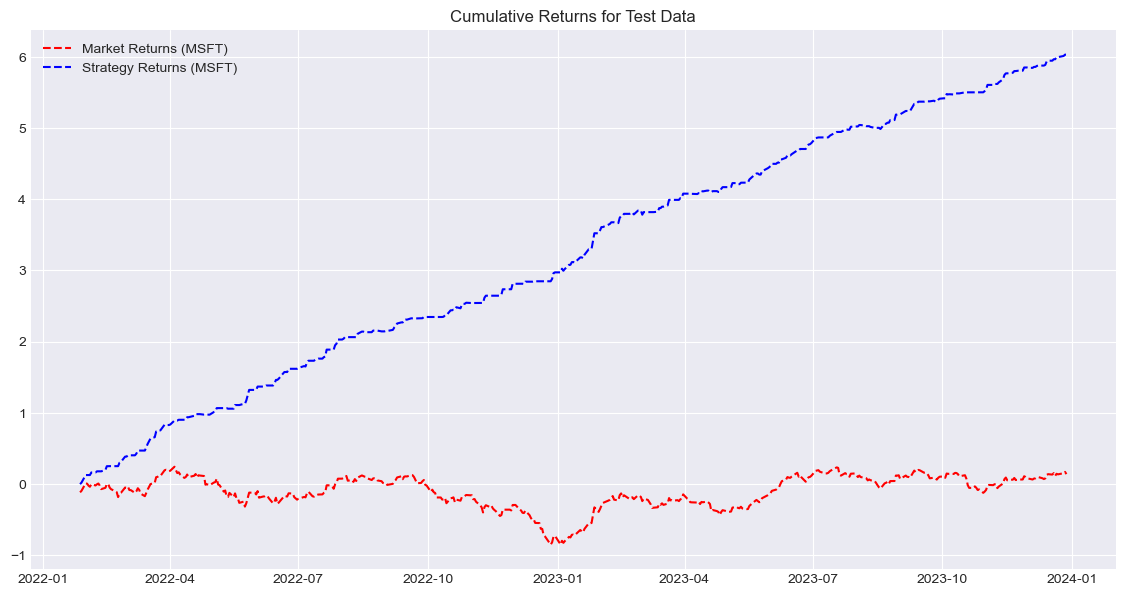

In [46]:
# Predict and plot strategy returns using the best model
df_test = df[split:].copy()  # Test data
df_test['Predicted_Signal'] = best_model.predict(X_test_scaled)
df_test['Return'] = df_test['Close'].pct_change()
df_test['Strategy_Return'] = df_test['Return'] * df_test['Predicted_Signal'].shift(1)
df_test['Cum_Ret'] = df_test['Return'].cumsum()
df_test['Cum_Strategy'] = df_test['Strategy_Return'].cumsum()

# Check for NaN values and plot
if df_test['Cum_Ret'].isnull().all() or df_test['Cum_Strategy'].isnull().all():
    print("NaN values in cumulative returns.")
else:
    plt.figure(figsize=(14, 7))
    plt.plot(df_test['Cum_Ret'], color='red', linestyle='--', label='Market Returns (MSFT)')
    plt.plot(df_test['Cum_Strategy'], color='blue', linestyle='--', label='Strategy Returns (MSFT)')
    plt.legend()
    plt.title('Cumulative Returns for Test Data')
    plt.show()

Backtesting period: 2020-12-28 to 2023-12-28
Starting Portfolio Value: 100000.00
Ending Portfolio Value: 403083.03


<Figure size 1400x700 with 0 Axes>

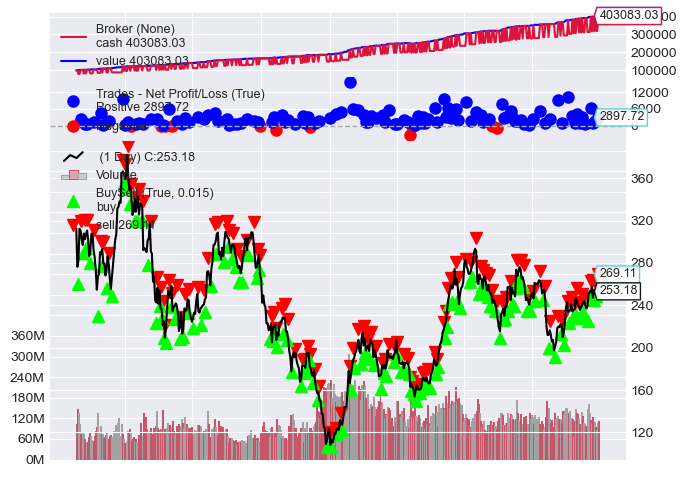

In [52]:
# Import necessary libraries
%matplotlib inline
import backtrader as bt
import matplotlib.pyplot as plt

# Create a custom data feed class that includes the 'Predicted_Signal'
class PandasDataWithPrediction(bt.feeds.PandasData):
    # Add a new line for the predicted signal
    lines = ('predicted_signal',)
    
    # Define the parameters to include the predicted signal
    params = (('predicted_signal', -1),)  # Default value of -1 to indicate the field index

# Backtrader Strategy for the best model
class MLStrategy(bt.Strategy):
    def __init__(self):
        self.signal = self.datas[0].predicted_signal

    def next(self):
        if self.signal[0] == 1:  # Buy signal
            if not self.position:  # Only buy if we don't have a position
                size = int((self.broker.getcash() * 0.2) // self.data.close[0])  # 10% of cash
                if size > 0:  # Ensure we're not trying to buy zero shares
                    self.buy(size=size)  # Buy shares based on available cash
        elif self.signal[0] == 0:  # Sell signal
            if self.position:  # Only sell if we have a position
                self.sell(size=self.position.size)  # Sell all shares



# Prepare the data for Backtrader
def prepare_data(df):
    # Ensure that required columns are present and formatted correctly
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Predicted_Signal']].copy()
    df['datetime'] = df.index  # Make sure the index (Date) is also included as a column for Backtrader

    # Create a Backtrader Data Feed with the custom class
    data = PandasDataWithPrediction(
        dataname=df,
        datetime='datetime',
        open='Open',
        high='High',
        low='Low',
        close='Close',
        volume='Volume',
        predicted_signal='Predicted_Signal',  # Custom field
        fromdate=df.index[0],
        todate=df.index[-1]
    )
    return data

# Function to backtest the model and display the plot
def backtest_model(df):
    # Get the end date for the test set
    end_date = df.index[-1]
    start_date = end_date - pd.DateOffset(years=3)  # Calculate the start date for 3 years ago

    # Filter the DataFrame to include only the last 3 years
    df_test = df.loc[start_date:end_date]  # Limit data to the last 3 years

    # Prepare data for Backtrader
    data = prepare_data(df_test)
    
    # Print the time period of the data
    print(f"Backtesting period: {start_date.date()} to {end_date.date()}")
    
    # Create a Backtrader Cerebro engine
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MLStrategy)
    cerebro.adddata(data)
    
    # Set initial capital
    cerebro.broker.setcash(100000.0)  # Starting with $1000
    cerebro.broker.setcommission(commission=0.000)  # Set commission
    
    # Run the backtest
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
    cerebro.run()
    print("Ending Portfolio Value: %.2f" % cerebro.broker.getvalue())
    
    # Plot the results using matplotlib
    plt.figure(figsize=(14, 7))  # Adjust figure size as needed
    cerebro.plot(iplot=False)  # Set iplot=False to avoid interactive mode
    plt.show()  # Display the plot in Jupyter Notebook



# Backtest the best model using df_test
backtest_model(df_test)


In [49]:
import alpaca_trade_api as tradeapi
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import time
from sklearn.preprocessing import StandardScaler

# Alpaca API Keys
API_KEY = "PK59HKZ8XDM9IAR0XMXP"
SECRET_KEY = "5VbepJ0OlgKD9kAfmy0eyCzlyEvlsUbERjW5g0HB"
BASE_URL = "https://paper-api.alpaca.markets"

# Connect to Alpaca API
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

# Function to fetch live data
def fetch_live_data(ticker, period='5d', interval='1m'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Function to make a trade
def trade(signal, ticker):
    if signal == 1:
        print(f"Buying {ticker}")
        api.submit_order(
            symbol=ticker,
            qty=1,  # Modify the quantity as needed
            side='buy',
            type='market',
            time_in_force='gtc'
        )
    elif signal == 0:
        print(f"Selling {ticker}")
        api.submit_order(
            symbol=ticker,
            qty=1,
            side='sell',
            type='market',
            time_in_force='gtc'
        )

# Predict and execute trade
def predict_and_trade(ticker):
    # Fetch live data
    df = fetch_live_data(ticker)
    
    # Prepare the DataFrame (same as you did before)
    df['Open-Close'] = (df["Open"] - df['Close']).shift(-1)
    df['Close-High'] = (df["Close"] - df['High']).shift(-1)
    df['Close-Low'] = (df["Close"] - df['Low']).shift(-1)
    df['High-Low'] = df['High'] - df['Low']
    df['Mid'] = (df['High'] + df['Low']) / 2
    
    # Calculate technical indicators (same as before)
    df['rsi'] = ta.RSI(df['Close'].values, timeperiod=14)
    df['adx'] = ta.ADX(df['High'].values, df['Low'].values, df['Open'].values, timeperiod=50)
    df['NATR'] = ta.NATR(df['High'], df['Low'], df['Close'], timeperiod=50)
    df['pct_change5'] = df['Close'].pct_change(5)
    df['pct_change'] = df['Close'].pct_change()
    df['sma'] = ta.SMA(df['Close'], timeperiod=30)
    df['corr'] = df['Close'].rolling(window=int(6.5*4)).corr(df['sma'])
    
    df.dropna(inplace=True)

    # Feature set
    X_live = df[['sma','pct_change','pct_change5','rsi', 'adx', 'corr', 'Volume', 'Open-Close', 'Close-Low', 'Close-High', 'High-Low','Mid']].copy()

    # Scale the features using the same scaler
    X_live_scaled = scaler.transform(X_live)

    # Use the trained model to predict
    predicted_signal = best_model.predict(X_live_scaled[-1].reshape(1, -1))[0]

    # Execute trade based on prediction
    trade(predicted_signal, ticker)

# Set the ticker symbol
ticker = "TSLA"

while True:
    predict_and_trade(ticker)
    time.sleep(60)  # Wait 1 minute before checking again


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


[*********************100%%**********************]  1 of 1 completed


Buying MSFT


APIError: forbidden.